In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Model with shared layers + two different heads
class MultiTaskNet(nn.Module):
    def __init__(self):
        super(MultiTaskNet, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU()
        )
        self.regression_head = nn.Linear(20, 1)  # Regression to a single value
        self.classification_head = nn.Linear(20, 10)  # Classification to 10 classes

    def forward(self, x):
        shared = self.shared_layers(x)
        return self.regression_head(shared), self.classification_head(shared)

# Data generation: 100 samples
data = torch.randn(100, 10)

# Regression targets: based on a non-linear combination of the data
regression_targets = torch.sin(data[:, 0]) + data[:, 1]**2 - data[:, 2] * data[:, 3]
regression_targets = regression_targets.view(-1, 1)

# Classification targets: 10 classes based on a certain logic
classification_targets = (data[:, 4] + data[:, 5]).long().clamp(0, 9)

dataloader = [(data[i], regression_targets[i], classification_targets[i]) for i in range(100)]

def loss_fn1(output, target):
    return nn.MSELoss()(output, target)

def loss_fn2(output, target):
    return nn.CrossEntropyLoss()(output, target)

def train(model, dataloader, optimizer, epochs=100):
    loss1_history = []  # Store total loss for each epoch
    loss2_history = []
    loss_history = [] 
    w1_history = []
    w2_history = []
    
    w1 = 1.0
    w2 = 1.0

    for epoch in range(epochs):
        total_l1 = 0
        total_l2 = 0
        total_loss = 0

        for data, reg_target, class_target in dataloader:
            optimizer.zero_grad()

            reg_output, class_output = model(data)

            l1 = loss_fn1(reg_output, reg_target)
            l2 = loss_fn2(class_output.view(1, -1), class_target.view(1).long())  # Adjusted for expected shape

            total_l1 += l1.item()
            total_l2 += l2.item()

            loss = w1 * l1 + w2 * l2
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Append total epoch losses to history
        loss1_history.append(total_l1)
        loss2_history.append(total_l2)
        loss_history.append(total_loss)

        # Update weights after every 10 epochs
        if (epoch >= 10):
            w1 = (torch.tensor(loss1_history[-10:]).var() + 1e-8)
            w2 = (torch.tensor(loss2_history[-10:]).var() + 1e-8)
        total=w1+w2
        w1 = w1/total
        w2 = w2/total
        w1_history.append(w1)
        w2_history.append(w2)

        print(f"Epoch {epoch + 1}/{epochs}, Loss1: {total_l1}, Loss2: {total_l2}, wLoss1: {w1}, wLoss2: {w2}")
    return (loss1_history, loss2_history, loss_history, w1_history, w2_history)

model = MultiTaskNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
(loss1_history, loss2_history, loss_history, w1_history, w2_history)=train(model, dataloader, optimizer)


Epoch 1/100, Loss1: 339.3397848432505, Loss2: 91.16427304093213, wLoss1: 0.5, wLoss2: 0.5
Epoch 2/100, Loss1: 239.6960950885259, Loss2: 48.78012675817081, wLoss1: 0.5, wLoss2: 0.5
Epoch 3/100, Loss1: 190.46003382778144, Loss2: 43.38251318852417, wLoss1: 0.5, wLoss2: 0.5
Epoch 4/100, Loss1: 160.65521239852802, Loss2: 36.6980921246286, wLoss1: 0.5, wLoss2: 0.5
Epoch 5/100, Loss1: 116.97850076283977, Loss2: 31.085354339822516, wLoss1: 0.5, wLoss2: 0.5
Epoch 6/100, Loss1: 73.30036824337003, Loss2: 26.079679531267175, wLoss1: 0.5, wLoss2: 0.5
Epoch 7/100, Loss1: 56.221914878459756, Loss2: 20.285954189304107, wLoss1: 0.5, wLoss2: 0.5
Epoch 8/100, Loss1: 56.3595977374498, Loss2: 18.847396692678096, wLoss1: 0.5, wLoss2: 0.5
Epoch 9/100, Loss1: 37.9465126197897, Loss2: 15.143173452483424, wLoss1: 0.5, wLoss2: 0.5
Epoch 10/100, Loss1: 68.59091700850695, Loss2: 15.516382230924812, wLoss1: 0.5, wLoss2: 0.5
Epoch 11/100, Loss1: 64.367393012697, Loss2: 14.864140039588953, wLoss1: 0.9679816365242004,

Epoch 72/100, Loss1: 4.890871814939942, Loss2: 1.1488161884833445, wLoss1: 0.3776942789554596, wLoss2: 0.622305691242218
Epoch 73/100, Loss1: 4.005418150024525, Loss2: 1.0507641671939396, wLoss1: 0.380338191986084, wLoss2: 0.6196617484092712
Epoch 74/100, Loss1: 3.989660244576953, Loss2: 0.9972305728605875, wLoss1: 0.38586992025375366, wLoss2: 0.6141300797462463
Epoch 75/100, Loss1: 3.2282710196050175, Loss2: 0.972064547932753, wLoss1: 0.5825886726379395, wLoss2: 0.41741132736206055
Epoch 76/100, Loss1: 4.272410411905867, Loss2: 0.8603124324496747, wLoss1: 0.9682256579399109, wLoss2: 0.03177432343363762
Epoch 77/100, Loss1: 6.157467868718527, Loss2: 0.8979459004300807, wLoss1: 0.9981705546379089, wLoss2: 0.0018294908804818988
Epoch 78/100, Loss1: 66.81909996239244, Loss2: 1.8192757595183977, wLoss1: 0.9997624158859253, wLoss2: 0.0002375446492806077
Epoch 79/100, Loss1: 136.08388418586037, Loss2: 10.84107760985927, wLoss1: 0.9951000213623047, wLoss2: 0.004899938125163317
Epoch 80/100, L

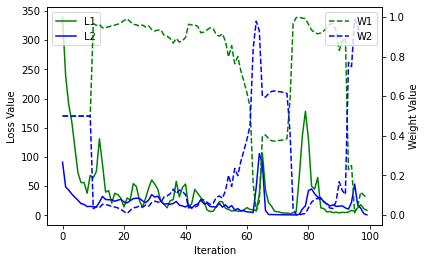

In [3]:
import matplotlib.pyplot as plt

# Plotting L1, L2, W1, and W2
fig, ax1 = plt.subplots()

# Twin the axes
ax2 = ax1.twinx()

# Plotting on the first y-axis
ax1.plot(loss1_history, label='L1', color='g')
ax1.plot(loss2_history, label='L2', color='b')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss Value')
ax1.legend(loc='upper left')

# Plotting on the second y-axis
ax2.plot(w1_history, label='W1', color='g', linestyle='dashed')
ax2.plot(w2_history, label='W2', color='b', linestyle='dashed')
ax2.set_ylabel('Weight Value')
ax2.legend(loc='upper right')

plt.show()
